In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np

# # Download a dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# # Batch and shuffle the data
# train_ds = tf.data.Dataset.from_tensor_slices(
#     (x_train.astype('float32') / 255, y_train)).shuffle(1024).batch(32)

# test_ds = tf.data.Dataset.from_tensor_slices(
#     (x_test.astype('float32') / 255, y_test)).batch(32)
print(tf.__version__)

2.0.0


In [19]:
from nus_wide_data_util import get_labeled_data, get_top_k_labels

class_num = 5

#top_k = get_top_k_labels('', top_k=class_num)
top_k = ['buildings', 'grass', 'animal', 'water', 'person']
print(top_k)

train_X_image, train_X_text, train_Y = get_labeled_data('', top_k, 60000, 'Train')
print(type(train_X_image), type(train_X_text), type(train_Y))
test_X_image, test_X_text, test_Y = get_labeled_data('', top_k, 40000, 'Test')
print(type(test_X_image), type(test_X_text), type(test_Y))

['buildings', 'grass', 'animal', 'water', 'person']
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
df shape (161789, 1)
(69966, 5)
data_dir: 
features_path: NUS_WIDE/NUS_WID_Low_Level_Features/Low_Level_Features
b datasets features 64
b datasets features 225
b datasets features 144
b datasets features 73
b datasets features 128
X image shape: (69966, 634)
X text shape: (69966, 1000)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
df shape (107859, 1)
df shape (107859, 1)
df shape (107859, 1)
df shape (107859, 1)
df shape (107859, 1)
(46693, 5)
data_dir: 
features_path: NUS_WIDE/NUS_WID_Low_Level_Features/Low_Level_Features
b datasets features 64
b datasets features 225
b datasets features 144
b datasets features 73
b datasets features 128
X image shape: (46693, 634)
X text shape: (46693, 1000)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [20]:
x_train, x_test, y_train, y_test = (np.array(train_X_image).astype('float32'), np.array(train_X_text).astype('float32')), \
                                    (np.array(test_X_image).astype('float32'), np.array(test_X_text).astype('float32')), \
                                    np.array(train_Y).astype('float32'), np.array(test_Y).astype('float32')

# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(1024).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32)

In [21]:
np.sum(y_test, axis=0)

array([ 4213.,  4082.,  8296.,  8172., 15237.], dtype=float32)

In [22]:
class VFLPassiveModel(Model):
    def __init__(self):
        super(VFLPassiveModel, self).__init__()
        self.flatten = Flatten()
        self.d1 = Dense(32, name="dense1", activation='relu')

    def call(self, x):
        x = self.flatten(x)
        return self.d1(x)

In [23]:
import numpy as np

class VFLActiveModelWithOneLayer(Model):
    def __init__(self):
        super(VFLActiveModelWithOneLayer, self).__init__()
        self.concatenated = tf.keras.layers.Concatenate()
        self.d1 = Dense(32, name="dense1", activation='relu')
        self.out = Dense(class_num, name="out", activation='softmax')

    def call(self, x):
        x = self.concatenated(x)
        x = self.d1(x)
        return self.out(x)
    
class VFLActiveModelWithTwoLayer(Model):
    def __init__(self):
        super(VFLActiveModelWithTwoLayer, self).__init__()
        self.concatenated = tf.keras.layers.Concatenate()
        self.d1 = Dense(32, name="dense1", activation='relu')
        self.d2 = Dense(32, name="dense2", activation='relu')
        self.out = Dense(class_num, name="out", activation='softmax')

    def call(self, x):
        x = self.concatenated(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.out(x)
    
class VFLActiveModelWithThreeLayer(Model):
    def __init__(self):
        super(VFLActiveModelWithThreeLayer, self).__init__()
        self.concatenated = tf.keras.layers.Concatenate()
        self.d1 = Dense(32, name="dense1", activation='relu')
        self.d2 = Dense(32, name="dense2", activation='relu')
        self.d3 = Dense(32, name="dense3", activation='relu')
        self.out = Dense(class_num, name="out", activation='softmax')

    def call(self, x):
        x = self.concatenated(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return self.out(x)
    
class VFLActiveModelWithFourLayer(Model):
    def __init__(self):
        super(VFLActiveModelWithFourLayer, self).__init__()
        self.concatenated = tf.keras.layers.Concatenate()
        self.d1 = Dense(32, name="dense1", activation='relu')
        self.d2 = Dense(32, name="dense2", activation='relu')
        self.d3 = Dense(32, name="dense3", activation='relu')
        self.d4 = Dense(32, name="dense4", activation='relu')
        self.out = Dense(class_num, name="out", activation='softmax')

    def call(self, x):
        x = self.concatenated(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return self.out(x)

In [24]:
import numpy as np

def get_poisoned_matrix(passive_matrix, need_poison, poison_grad, amplify_rate):
    #print(passive_matrix)
    poisoned_matrix = passive_matrix.numpy()
    poisoned_matrix[need_poison] = poison_grad*amplify_rate
    poisoned_matrix = tf.convert_to_tensor(poisoned_matrix, tf.float32, name='poisoned_matrix')
    return poisoned_matrix

def copy_grad(passive_matrix, need_copy):
    poison_grad = passive_matrix[need_copy].numpy()
    return poison_grad[0]

In [25]:
import copy

(image_test, text_test) = x_test
image_backdoor = image_test[text_test[:,-1]==1]
text_backdoor = text_test[text_test[:,-1]==1]
y_backdoor = copy.deepcopy(y_test[text_test[:,-1]==1])

np.sum(y_backdoor, axis=0)
print(np.sum(x_train[1][:,-1]))
print(np.sum(x_test[1][:,-1]))



152.0
102.0


In [26]:
training_mode_list = ['backdoor', 'normal', 'backdoor_with_laplace_noise_0.1', 'backdoor_with_laplace_noise_0.01'\
                    , 'backdoor_with_laplace_noise_0.001', 'backdoor_with_laplace_noise_0.0001'\
                    , 'backdoor_with_gaussian_noise_0.1', 'backdoor_with_gaussian_noise_0.01'\
                    , 'backdoor_with_gaussian_noise_0.001', 'backdoor_with_gaussian_noise_0.0001'\
                    , 'backdoor_with_gradient_sparsification_95', 'backdoor_with_gradient_sparsification_99'\
                    , 'backdoor_with_gradient_sparsification_99.5', 'backdoor_with_gradient_sparsification_99.9'\
                    , 'backdoor_with_one_hidden_layer', 'backdoor_with_two_hidden_layer'\
                    , 'backdoor_with_three_hidden_layer', 'backdoor_with_four_hidden_layer']

result_list = []
for indx in range(len(training_mode_list)):
    result_list.append([])

In [32]:
from sklearn import metrics

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_label_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_label_accuracy')

backdoor_loss = tf.keras.metrics.Mean(name='backdoor_loss')
backdoor_accuracy = tf.keras.metrics.CategoricalAccuracy(name='backdoor_accuracy')

number_of_times = 1
EPOCHS = 50

sample_id_need_copy = 369
text_feat_need_copy = copy.deepcopy(x_train[1][sample_id_need_copy])
y_backdoor[:] = y_train[sample_id_need_copy]

mode_need_train_list = ['normal']
# mode_need_train_list = training_mode_list

for indx in range(len(training_mode_list)):
    if training_mode_list[indx] in mode_need_train_list:
        result_list[indx] = []

for t in range(number_of_times):
    for indx in range(len(training_mode_list)):
        training_mode = training_mode_list[indx]
        if training_mode not in mode_need_train_list:
            continue
        passive_model_image = VFLPassiveModel()
        passive_model_text = VFLPassiveModel()
        if 'two_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithTwoLayer()
        elif 'three_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithThreeLayer()
        elif 'four_hidden_layer' in training_mode:
            active_model = VFLActiveModelWithFourLayer()
        else:
            active_model = VFLActiveModelWithOneLayer()
        print('training_mode = ', training_mode)

        acc_train = []
        acc_test = []
        acc_test_label = [[], [], [], [], [], []]
        acc_backdoor = []
        loss_train = []
        loss_test = []
        loss_backdoor = []

        active_image_gradients_res = None
        active_text_gradients_res = None
        has_poison_grad = False
        for epoch in range(EPOCHS):
            # Batch and shuffle the data
            train_ds = tf.data.Dataset.from_tensor_slices(
                (x_train, y_train)).shuffle(65535).batch(64)
            # For each batch of images and labels
            number_of_poison = 0
            gradient_record_list = []
            for (images, texts), labels in train_ds:
                need_copy = np.min((texts == text_feat_need_copy).numpy(), axis=1)
                with tf.GradientTape() as passive_tape:
                    # passive_model sends passive_output to active_model
                    passive_image_output = passive_model_image(images)
                    poisoned_text_output = passive_text_output = passive_model_text(texts)
                    if 'backdoor' in training_mode:
                        need_poison = (texts.numpy()[:,-1] == 1)
                        if np.sum(need_poison) > 0:
                            if has_poison_grad:
                                poisoned_text_output = get_poisoned_matrix(passive_text_output, need_poison, poison_grad, 0)
                    with tf.GradientTape() as active_tape:
                        active_tape.watch(passive_image_output)
                        active_tape.watch(poisoned_text_output)
                        active_output = active_model([passive_image_output, poisoned_text_output])
                        loss = loss_object(labels, active_output)
                    # active_model sends passive_output_gradients back to passive_model
                    [active_image_gradients, active_text_gradients, active_model_gradients] = \
                    active_tape.gradient(loss, [passive_image_output, poisoned_text_output, active_model.trainable_variables])
                    optimizer.apply_gradients(zip(active_model_gradients, active_model.trainable_variables))

                    location = 0.0
                    threshold = 5
                    if 'laplace' in training_mode:
                        scale = float(training_mode.split('_')[-1])
                        active_image_gradients = tf.clip_by_value(active_image_gradients, -threshold, threshold)
                        active_text_gradients = tf.clip_by_value(active_text_gradients, -threshold, threshold)
                        active_image_gradients += np.random.laplace(location, scale, active_image_gradients.numpy().shape)
                        active_text_gradients += np.random.laplace(location, scale, active_text_gradients.numpy().shape)
                    if 'gaussian' in training_mode:
                        scale = float(training_mode.split('_')[-1])
                        active_image_gradients = tf.clip_by_value(active_image_gradients, -threshold, threshold)
                        active_text_gradients = tf.clip_by_value(active_text_gradients, -threshold, threshold)
                        active_image_gradients += np.random.normal(location, scale, active_image_gradients.numpy().shape)
                        active_text_gradients += np.random.normal(location, scale, active_text_gradients.numpy().shape)
                    if 'sparsification' in training_mode:
                        percent = float(training_mode.split('_')[-1])
                        if active_image_gradients_res is not None and \
                        active_image_gradients.shape[0] == active_image_gradients_res.shape[0]:
                            # print(active_image_gradients.shape, active_image_gradients_res.shape)
                            active_image_gradients = active_image_gradients + active_image_gradients_res
                        if active_text_gradients_res is not None and \
                        active_text_gradients.shape[0] == active_text_gradients_res.shape[0]:
                            # print(active_text_gradients.shape, active_text_gradients_res.shape)
                            active_text_gradients = active_text_gradients + active_text_gradients_res
                        image_thr = np.percentile(np.abs(active_image_gradients.numpy()), percent)
                        text_thr = np.percentile(np.abs(active_text_gradients.numpy()), percent)
                        image_mask = np.abs(active_image_gradients.numpy()) < image_thr
                        text_mask = np.abs(active_text_gradients.numpy()) < text_thr
                        active_image_gradients_res = np.multiply(active_image_gradients.numpy(), image_mask)
                        active_text_gradients_res = np.multiply(active_text_gradients.numpy(), text_mask)
                        active_image_gradients -= active_image_gradients_res
                        active_text_gradients -= active_text_gradients_res
                    if np.sum(need_copy) > 0:
                        poison_grad = copy_grad(active_text_gradients, need_copy)
                        has_poison_grad = True
                        print('need_copy')
                        #print(active_output[need_copy])
                        #print(labels[need_copy])
                    elif has_poison_grad == False:
                        poison_grad = active_text_gradients.numpy()[0]*0
                        has_poison_grad = True
                    if  'backdoor' in training_mode:
                        need_poison = (texts.numpy()[:,-1] == 1)
                        if np.sum(need_poison) > 0:
                            if has_poison_grad:
                                number_of_poison += np.sum(need_poison)
                                active_text_gradients = get_poisoned_matrix(active_text_gradients, need_poison, poison_grad)
                    passive_image_loss = tf.multiply(passive_image_output, active_image_gradients.numpy())
                    passive_text_loss = tf.multiply(passive_text_output, active_text_gradients.numpy())
                [passive_image_gradients, passive_text_gradients] = \
                passive_tape.gradient([passive_image_loss, passive_text_loss], \
                                      [passive_model_image.trainable_variables, passive_model_text.trainable_variables])
                optimizer.apply_gradients(zip(passive_image_gradients, passive_model_image.trainable_variables))
                optimizer.apply_gradients(zip(passive_text_gradients, passive_model_text.trainable_variables))

                train_loss(loss)
                train_accuracy(labels, active_output)

                passive_output = [passive_model_image(image_backdoor), passive_model_text(text_backdoor)]
                active_output = active_model(passive_output)

                backdoor_loss.reset_states()
                backdoor_accuracy.reset_states()

                backdoor_loss(loss_object(y_backdoor, active_output))
                backdoor_acc = backdoor_accuracy(y_backdoor, active_output)

            for (test_images, test_texts), test_labels in test_ds:
                passive_output = [passive_model_image(test_images), passive_model_text(test_texts)]
                active_output = active_model(passive_output)
                t_loss = loss_object(test_labels, active_output)
                test_loss(t_loss)
                test_accuracy(test_labels, active_output)

            label_test = np.argmax(y_test, axis=1)
            for label_val in range(class_num):
                (image_test, text_test) = x_test
                image_val = image_test[label_test==label_val]
                text_val = text_test[label_test==label_val]
                #print(image_val.shape, text_val.shape)
                y_val = y_test[label_test==label_val]
                passive_output = [passive_model_image(image_val), passive_model_text(text_val)]
                active_output = active_model(passive_output)
                test_label_accuracy.reset_states()
                tl_acc = test_label_accuracy(y_val, active_output)
                acc_test_label[label_val].append(tl_acc.numpy())

            acc_test_label[class_num].append(backdoor_accuracy.result())
            acc_backdoor.append(backdoor_accuracy.result())
            loss_train.append(train_loss.result())
            loss_test.append(test_loss.result())
            loss_backdoor.append(backdoor_loss.result())

            template = 'Epoch {}, Poisoned {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Backdoor Accuracy: {}'
            print(template.format(epoch+1,
                                number_of_poison,
                                train_loss.result(),
                                train_accuracy.result()*100,
                                test_loss.result(),
                                test_accuracy.result()*100,
                                backdoor_accuracy.result()*100))
            acc_train.append(train_accuracy.result())
            acc_test.append(test_accuracy.result())

            # Reset the metrics for the next epoch
            train_loss.reset_states()
            train_accuracy.reset_states()
            test_loss.reset_states()
            test_accuracy.reset_states()
        for sub_indx in range(EPOCHS):
            acc_test[sub_indx] /= number_of_times
            acc_backdoor[sub_indx] /= number_of_times
            loss_train[sub_indx] /= number_of_times
            loss_test[sub_indx] /= number_of_times
            loss_backdoor[sub_indx] /= number_of_times
#         if len(result_list[indx]) != 0:
#             for sub_indx in range(EPOCHS):
#                 acc_test[sub_indx] += result_list[indx][1][sub_indx]
#                 acc_backdoor[sub_indx] += result_list[indx][3][sub_indx]
#                 loss_test[sub_indx] += result_list[indx][4][sub_indx]
#                 loss_backdoor[sub_indx] += result_list[indx][5][sub_indx]
        result_list[indx] = [acc_train, acc_test, acc_test_label, acc_backdoor, loss_train, loss_test, loss_backdoor]

training_mode =  normal
need_copy
Epoch 1, Poisoned 0, Loss: 1.1860820055007935, Accuracy: 53.63500213623047, Test Loss: 0.9480444192886353, Test Accuracy: 64.65499877929688, Backdoor Accuracy: 0.9803922176361084
need_copy
Epoch 2, Poisoned 0, Loss: 0.8029346466064453, Accuracy: 71.03499603271484, Test Loss: 0.6986792087554932, Test Accuracy: 75.13500213623047, Backdoor Accuracy: 0.9803922176361084
need_copy
Epoch 3, Poisoned 0, Loss: 0.5992596745491028, Accuracy: 79.32500457763672, Test Loss: 0.5486399531364441, Test Accuracy: 80.94999694824219, Backdoor Accuracy: 0.0
need_copy
Epoch 4, Poisoned 0, Loss: 0.4917519986629486, Accuracy: 83.1300048828125, Test Loss: 0.47752684354782104, Test Accuracy: 83.56749725341797, Backdoor Accuracy: 1.9607844352722168
need_copy
Epoch 5, Poisoned 0, Loss: 0.43591228127479553, Accuracy: 85.14166259765625, Test Loss: 0.4390772879123688, Test Accuracy: 84.89999389648438, Backdoor Accuracy: 1.9607844352722168
need_copy
Epoch 6, Poisoned 0, Loss: 0.401049

need_copy
Epoch 47, Poisoned 0, Loss: 0.19865640997886658, Accuracy: 93.22999572753906, Test Loss: 0.34834012389183044, Test Accuracy: 88.70000457763672, Backdoor Accuracy: 0.0
need_copy
Epoch 48, Poisoned 0, Loss: 0.19681937992572784, Accuracy: 93.32833099365234, Test Loss: 0.35052865743637085, Test Accuracy: 88.6675033569336, Backdoor Accuracy: 0.0
need_copy
Epoch 49, Poisoned 0, Loss: 0.19503742456436157, Accuracy: 93.3066635131836, Test Loss: 0.3519189655780792, Test Accuracy: 88.6300048828125, Backdoor Accuracy: 0.0
need_copy
Epoch 50, Poisoned 0, Loss: 0.19297437369823456, Accuracy: 93.44000244140625, Test Loss: 0.35225462913513184, Test Accuracy: 88.64749908447266, Backdoor Accuracy: 0.0


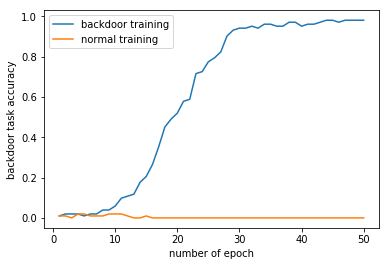

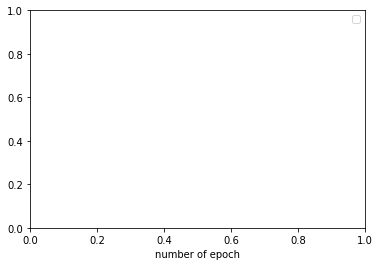

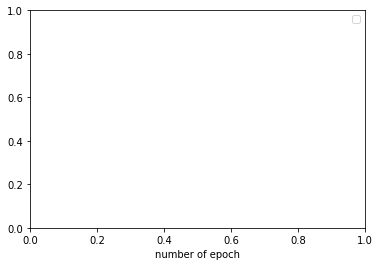

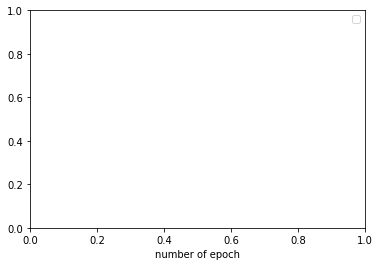

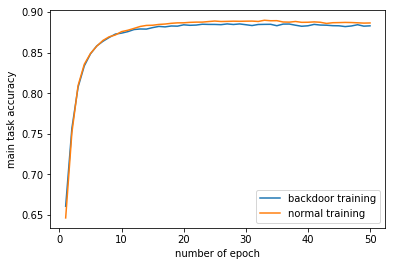

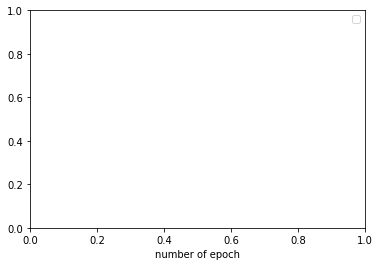

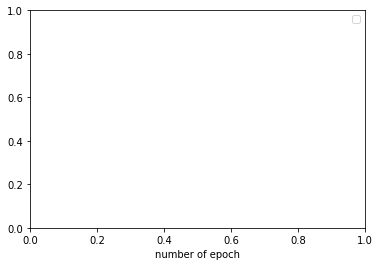

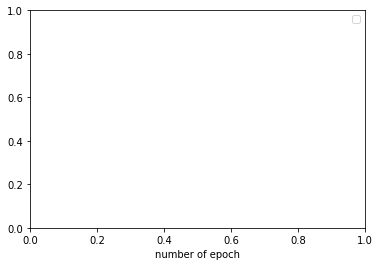

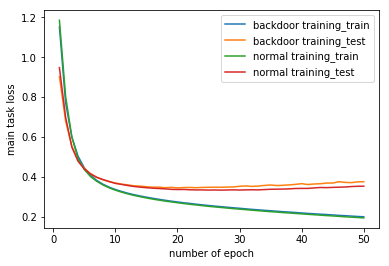

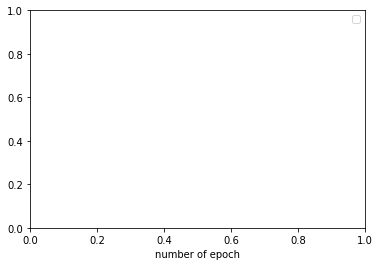

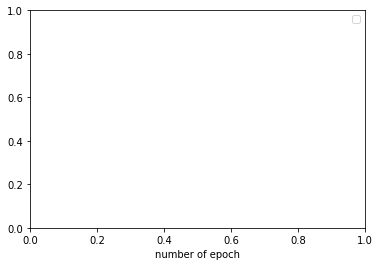

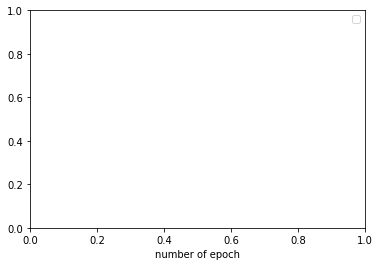

In [33]:
import matplotlib.pyplot as plt

figure_name_lst = ['exp3_normal_backdoor_task_accuracy.png', 'exp3_laplace_backdoor_task_accuracy.png',\
                   'exp3_gaussian_backdoor_task_accuracy.png', 'exp3_sparsification_backdoor_task_accuracy.png',\
                   'exp3_normal_main_task_accuracy.png', 'exp3_laplace_main_task_accuracy.png',\
                   'exp3_gaussian_main_task_accuracy.png', 'exp3_sparsification_main_task_accuracy.png',\
                   'exp3_normal_main_task_loss.png', 'exp3_laplace_main_task_loss.png', \
                   'exp3_gaussian_main_task_loss.png', 'exp3_sparsification_main_task_loss.png']
label_show_lst = [['normal', 'backdoor'], ['backdoor_with_laplace_noise_0.1', 'backdoor_with_laplace_noise_0.01'\
              , 'backdoor_with_laplace_noise_0.001', 'backdoor_with_laplace_noise_0.0001']\
              ,['backdoor_with_gaussian_noise_0.1', 'backdoor_with_gaussian_noise_0.01'\
              , 'backdoor_with_gaussian_noise_0.001', 'backdoor_with_gaussian_noise_0.0001']\
              ,['backdoor_with_gradient_sparsification_95', 'backdoor_with_gradient_sparsification_99'\
              , 'backdoor_with_gradient_sparsification_99.5', 'backdoor_with_gradient_sparsification_99.9']]
for (figure_name, label_show) in zip(figure_name_lst, label_show_lst*3):
    data_size = EPOCHS
    x = list(range(1, data_size+1))
    label_lst = []
    l_lst = []
    for indx in range(len(training_mode_list)):
        label = training_mode_list[indx]
        if label in label_show and len(result_list[indx]) > 0:
            [acc_train, acc_test, acc_test_label, acc_backdoor, loss_train, loss_test, loss_backdoor] = result_list[indx]
            if 'backdoor_with_' in label:
                label_legend = label[len('backdoor_with_'):]
            else:
                label_legend = label + ' training'
            
            if 'backdoor_task_accuracy' in figure_name:
                l, = plt.plot(x, acc_backdoor[:data_size])
                l_lst.append(l)
                label_lst.append(label_legend)
                plt.ylabel('backdoor task accuracy')
            elif 'main_task_accuracy' in figure_name:
                l, = plt.plot(x, acc_test[:data_size])
                l_lst.append(l)
                label_lst.append(label_legend)
                plt.ylabel('main task accuracy')
            elif 'main_task_loss' in figure_name:
                l, = plt.plot(x, loss_train[:data_size])
                l_lst.append(l)
                label_lst.append(label_legend+'_train')
                l, = plt.plot(x, loss_test[:data_size])
                l_lst.append(l)
                label_lst.append(label_legend+'_test')
                plt.ylabel('main task loss')

    plt.legend(l_lst, label_lst, loc = 'best')
   # plt.ylim(0, 1.1)
    plt.xlabel('number of epoch')

    plt.savefig(figure_name)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

figure_name_lst = ['exp3_laplace_backdoor_task_accuracy.png', 'exp3_gaussian_backdoor_task_accuracy.png',\
                   'exp3_sparsification_backdoor_task_accuracy.png', 'exp3_multi-layer_backdoor_task_accuracy.png']
label_show_lst = [[ 'laplace_noise_0.1', 'laplace_noise_0.075'\
              , 'laplace_noise_0.05', 'laplace_noise_0.025']\
              ,['gaussian_noise_0.1', 'gaussian_noise_0.075'\
              , 'gaussian_noise_0.05', 'gaussian_noise_0.025']\
              ,['gradient_sparsification_95', 'gradient_sparsification_99'\
              , 'gradient_sparsification_99.5', 'gradient_sparsification_99.9']\
              ,['one_hidden_layer', 'two_hidden_layer'\
              , 'three_hidden_layer', 'four_hidden_layer']]
for (figure_name, label_show) in zip(figure_name_lst, label_show_lst):
    data_size = EPOCHS
    x = list(range(data_size))
    label_lst = []
    l_lst = []
    for indx in range(len(training_mode_list)):
        label = training_mode_list[indx][14:]
        if label in label_show and len(result_list[indx]) == 4:
            [acc_train, acc_test, acc_test_label, acc_backdoor] = result_list[indx]
            l, = plt.plot(x, acc_backdoor[:data_size])
            l_lst.append(l)
            label_lst.append(label)

    plt.legend(l_lst, label_lst, loc = 'best')
    plt.ylim(0, 1.0)
    plt.xlabel('number of epoch')
    plt.ylabel('backdoor task accuracy')

    plt.savefig(figure_name)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

figure_name_lst = ['exp3_laplace_main_task_accuracy.png', 'exp3_gaussian_main_task_accuracy.png',\
                   'exp3_sparsification_main_task_accuracy.png', 'exp3_multi-layer_main_task_accuracy.png']
label_show_lst = [[ 'laplace_noise_0.1', 'laplace_noise_0.075'\
              , 'laplace_noise_0.05', 'laplace_noise_0.025']\
              ,['gaussian_noise_0.1', 'gaussian_noise_0.075'\
              , 'gaussian_noise_0.05', 'gaussian_noise_0.025']\
              ,['gradient_sparsification_95', 'gradient_sparsification_99'\
              , 'gradient_sparsification_99.5', 'gradient_sparsification_99.9']\
              ,['one_hidden_layer', 'two_hidden_layer'\
              , 'three_hidden_layer', 'four_hidden_layer']]
for (figure_name, label_show) in zip(figure_name_lst, label_show_lst):
    data_size = EPOCHS
    x = list(range(data_size))
    label_lst = []
    l_lst = []
    for indx in range(len(training_mode_list)):
        label = training_mode_list[indx][14:]
        if label in label_show and len(result_list[indx]) == 4:
            [acc_train, acc_test, acc_test_label, acc_backdoor] = result_list[indx]
            l, = plt.plot(x, acc_test[:data_size])
            l_lst.append(l)
            label_lst.append(label)

    plt.legend(l_lst, label_lst, loc = 'best')
    plt.ylim(0, 1.0)
    plt.xlabel('number of epoch')
    plt.ylabel('main task accuracy')

    plt.savefig(figure_name)
    plt.show()

In [ ]:
from sklearn import metrics

training_mode_list = ['normal', 'A_backdoor_with_laplace_noise', 'A_backdoor_with_gaussian_noise', 'A_backdoor_with_gradient_sparsification', 'A_backdoor']

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_label_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_label_accuracy')

backdoor_loss = tf.keras.metrics.Mean(name='backdoor_loss')
backdoor_accuracy = tf.keras.metrics.CategoricalAccuracy(name='backdoor_accuracy')

EPOCHS = 50

sample_id_need_copy = 369
text_feat_need_copy = copy.deepcopy(x_train[1][sample_id_need_copy])
y_backdoor[:] = y_train[sample_id_need_copy]

for training_mode in training_mode_list[3:4]:
    passive_model_image = VFLPassiveModel()
    passive_model_text = VFLPassiveModel()
    active_model = VFLActiveModelWithOneLayer()
    print('training_mode = ', training_mode)
    if 'normal' == training_mode:
        normal_acc_train = []
        normal_acc_test = []
        normal_acc_test_label = [[], [], [], [], [], []]
        normal_acc_backdoor = []
    if 'A_backdoor' == training_mode:
        A_acc_train = []
        A_acc_test = []
        A_acc_test_label = [[], [], [], [], [], []]
        A_acc_backdoor = []
    if 'A_backdoor_with_laplace_noise' == training_mode:
        laplace_acc_train = []
        laplace_acc_test = []
        laplace_acc_test_label = [[], [], [], [], [], []]
        laplace_acc_backdoor = []
    if 'A_backdoor_with_gaussian_noise' == training_mode:
        gaussian_acc_train = []
        gaussian_acc_test = []
        gaussian_acc_test_label = [[], [], [], [], [], []]
        gaussian_acc_backdoor = []
    if 'A_backdoor_with_gradient_sparsification' == training_mode:
        sparsification_acc_train = []
        sparsification_acc_test = []
        sparsification_acc_test_label = [[], [], [], [], [], []]
        sparsification_acc_backdoor = []
        active_image_gradients_res = None
        active_text_gradients_res = None
    has_poison_grad = False
    for epoch in range(EPOCHS):
        # Batch and shuffle the data
        train_ds = tf.data.Dataset.from_tensor_slices(
            (x_train, y_train)).shuffle(65535).batch(64)
        # For each batch of images and labels
        number_of_poison = 0
        gradient_record_list = []
        for (images, texts), labels in train_ds:
            need_copy = np.min((texts == text_feat_need_copy).numpy(), axis=1)
            with tf.GradientTape() as passive_tape:
                # passive_model sends passive_output to active_model
                passive_image_output = passive_model_image(images)
                poisoned_text_output = passive_text_output = passive_model_text(texts)
                if 'A_backdoor' in training_mode:
                    need_poison = (texts[:,-1] == 1).numpy()
                    if np.sum(need_poison) > 0:
                        if has_poison_grad:
                            poisoned_text_output = get_poisoned_matrix(passive_text_output, need_poison, poison_grad)
                with tf.GradientTape() as active_tape:
                    active_tape.watch(passive_image_output)
                    active_tape.watch(poisoned_text_output)
                    active_output = active_model([passive_image_output, poisoned_text_output])
                    loss = loss_object(labels, active_output)
                # active_model sends passive_output_gradients back to passive_model
                [active_image_gradients, active_text_gradients, active_model_gradients] = \
                active_tape.gradient(loss, [passive_image_output, poisoned_text_output, active_model.trainable_variables])
                optimizer.apply_gradients(zip(active_model_gradients, active_model.trainable_variables))
                
                location = 0.0
                scale = 0.05
                threshold = 1e9
                if 'laplace' in training_mode:
                    active_image_gradients = tf.clip_by_value(active_image_gradients, -threshold, threshold)
                    active_text_gradients = tf.clip_by_value(active_text_gradients, -threshold, threshold)
                    active_image_gradients += np.random.laplace(location, scale, active_image_gradients.numpy().shape)
                    active_text_gradients += np.random.laplace(location, scale, active_text_gradients.numpy().shape)
                if 'gaussian' in training_mode:
                    active_image_gradients = tf.clip_by_value(active_image_gradients, -threshold, threshold)
                    active_text_gradients = tf.clip_by_value(active_text_gradients, -threshold, threshold)
                    active_image_gradients += np.random.normal(location, scale, active_image_gradients.numpy().shape)
                    active_text_gradients += np.random.normal(location, scale, active_text_gradients.numpy().shape)
                if 'sparsification' in training_mode:
                    percent = 99.0
                    if active_image_gradients_res is not None and \
                    active_image_gradients.shape[0] == active_image_gradients_res.shape[0]:
                        # print(active_image_gradients.shape, active_image_gradients_res.shape)
                        active_image_gradients = active_image_gradients + active_image_gradients_res
                    if active_text_gradients_res is not None and \
                    active_text_gradients.shape[0] == active_text_gradients_res.shape[0]:
                        # print(active_text_gradients.shape, active_text_gradients_res.shape)
                        active_text_gradients = active_text_gradients + active_text_gradients_res
                    image_thr = np.percentile(np.abs(active_image_gradients.numpy()), percent)
                    text_thr = np.percentile(np.abs(active_text_gradients.numpy()), percent)
                    image_mask = np.abs(active_image_gradients.numpy()) < image_thr
                    text_mask = np.abs(active_text_gradients.numpy()) < text_thr
                    active_image_gradients_res = np.multiply(active_image_gradients.numpy(), image_mask)
                    active_text_gradients_res = np.multiply(active_text_gradients.numpy(), text_mask)
                    active_image_gradients -= active_image_gradients_res
                    active_text_gradients -= active_text_gradients_res
                if np.sum(need_copy) > 0:
                    poison_grad = copy_grad(active_text_gradients, need_copy)
                    has_poison_grad = True
                    print('need_copy')
                    #print(active_output[need_copy])
                    #print(labels[need_copy])
                elif has_poison_grad == False:
                    poison_grad = active_text_gradients.numpy()[0]*0
                    has_poison_grad = True
                if  'A_backdoor' in training_mode:
                    need_poison = (texts[:,-1] == 1).numpy()
                    if np.sum(need_poison) > 0:
                        if has_poison_grad:
                            number_of_poison += np.sum(need_poison)
                            active_text_gradients = get_poisoned_matrix(active_text_gradients, need_poison, poison_grad)
                passive_image_loss = tf.multiply(passive_image_output, active_image_gradients.numpy())
                passive_text_loss = tf.multiply(passive_text_output, active_text_gradients.numpy())
            [passive_image_gradients, passive_text_gradients] = \
            passive_tape.gradient([passive_image_loss, passive_text_loss], \
                                  [passive_model_image.trainable_variables, passive_model_text.trainable_variables])
            optimizer.apply_gradients(zip(passive_image_gradients, passive_model_image.trainable_variables))
            optimizer.apply_gradients(zip(passive_text_gradients, passive_model_text.trainable_variables))

            train_loss(loss)
            train_accuracy(labels, active_output)

            passive_output = [passive_model_image(image_backdoor), passive_model_text(text_backdoor)]
            active_output = active_model(passive_output)

            backdoor_loss.reset_states()
            backdoor_accuracy.reset_states()
            
            backdoor_loss(loss_object(y_backdoor, active_output))
            backdoor_acc = backdoor_accuracy(y_backdoor, active_output)

            if 'normal' == training_mode:
                normal_acc_backdoor.append(backdoor_acc.numpy())
            if 'A_backdoor' == training_mode:
                A_acc_backdoor.append(backdoor_acc.numpy())
            if 'A_backdoor_with_laplace_noise' == training_mode:
                laplace_acc_backdoor.append(backdoor_acc.numpy())
            if 'A_backdoor_with_gaussian_noise' == training_mode:
                gaussian_acc_backdoor.append(backdoor_acc.numpy())
            if 'A_backdoor_with_gradient_sparsification' == training_mode:
                sparsification_acc_backdoor.append(backdoor_acc.numpy())
        for (test_images, test_texts), test_labels in test_ds:
            passive_output = [passive_model_image(test_images), passive_model_text(test_texts)]
            active_output = active_model(passive_output)
            t_loss = loss_object(test_labels, active_output)

            test_loss(t_loss)
            test_accuracy(test_labels, active_output)
        
        label_test = np.argmax(y_test, axis=1)
        for label_val in range(class_num):
            (image_test, text_test) = x_test
            image_val = image_test[label_test==label_val]
            text_val = text_test[label_test==label_val]
            #print(image_val.shape, text_val.shape)
            y_val = y_test[label_test==label_val]
            passive_output = [passive_model_image(image_val), passive_model_text(text_val)]
            active_output = active_model(passive_output)

            test_label_accuracy.reset_states()
            tl_acc = test_label_accuracy(y_val, active_output)
            
            if 'normal' == training_mode:
                normal_acc_test_label[label_val].append(tl_acc.numpy())
            if 'A_backdoor' == training_mode:
                A_acc_test_label[label_val].append(tl_acc.numpy())
            if 'A_backdoor_with_laplace_noise' == training_mode:
                laplace_acc_test_label[label_val].append(tl_acc.numpy())
            if 'A_backdoor_with_gaussian_noise' == training_mode:
                gaussian_acc_test_label[label_val].append(tl_acc.numpy())
            if 'A_backdoor_with_gradient_sparsification' == training_mode:
                sparsification_acc_test_label[label_val].append(tl_acc.numpy())
        if 'normal' == training_mode:
            normal_acc_test_label[class_num].append(backdoor_acc.numpy())
        if 'A_backdoor' == training_mode:
            A_acc_test_label[class_num].append(backdoor_acc.numpy())
        if 'A_backdoor_with_laplace_noise' == training_mode:
            laplace_acc_test_label[class_num].append(backdoor_acc.numpy())
        if 'A_backdoor_with_gaussian_noise' == training_mode:
            gaussian_acc_test_label[class_num].append(backdoor_acc.numpy())
        if 'A_backdoor_with_gradient_sparsification' == training_mode:
            sparsification_acc_test_label[class_num].append(backdoor_acc.numpy())

        template = 'Epoch {}, Poisoned {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, Backdoor Accuracy: {}'
        print(template.format(epoch+1,
                            number_of_poison,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100,
                            backdoor_accuracy.result()*100))
        if 'normal' == training_mode:
            normal_acc_train.append(train_accuracy.result())
            normal_acc_test.append(test_accuracy.result())
        if 'A_backdoor' == training_mode:
            A_acc_train.append(train_accuracy.result())
            A_acc_test.append(test_accuracy.result())
        if 'A_backdoor_with_laplace_noise' == training_mode:
            laplace_acc_train.append(train_accuracy.result())
            laplace_acc_test.append(test_accuracy.result())
        if 'A_backdoor_with_gaussian_noise' == training_mode:
            gaussian_acc_train.append(train_accuracy.result())
            gaussian_acc_test.append(test_accuracy.result())
        if 'A_backdoor_with_gradient_sparsification' == training_mode:
            sparsification_acc_train.append(train_accuracy.result())
            sparsification_acc_test.append(test_accuracy.result())
        
        # Reset the metrics for the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()


In [ ]:
import matplotlib.pyplot as plt

data_size = 40

x = list(range(data_size))
label_lst = ['normal', 'backdoor', 'backdoor_with_laplace_noise', 'backdoor_with_gaussian_noise', 'backdoor_with_gradient_sparsification']
l_lst = []
for label in label_lst:
    if label == 'normal':
        l, = plt.plot(x, normal_acc_test[:data_size])
    if label == 'backdoor':
        l, = plt.plot(x, A_acc_test[:data_size])
    if label == 'backdoor_with_laplace_noise':
        l, = plt.plot(x, laplace_acc_test[:data_size])
    if label == 'backdoor_with_gaussian_noise':
        l, = plt.plot(x, gaussian_acc_test[:data_size])
    if label == 'backdoor_with_gradient_sparsification':
        l, = plt.plot(x, sparsification_acc_test[:data_size])
    l_lst.append(l)

plt.legend(l_lst, label_lst, loc = 'best')
plt.ylim(0.2, 1.0)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')

plt.savefig('exp2_validation_accuracy.png')
plt.show()

In [ ]:
data_size = 40

x = list(range(data_size))

label_lst = []
l_lst = []

for label_val in range(class_num+1):
    l, = plt.plot(x, A_acc_test_label[label_val][:data_size])
    if label_val == class_num:
        label_lst.append('backdoor task')
    else:
        label_lst.append('class_'+str(label_val))
    l_lst.append(l)
    
plt.legend(l_lst, label_lst, loc = 'best')

plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')

plt.savefig('exp2_class_validation_accuracy.png')
plt.show()

In [ ]:
data_size = 40

x = list(range(data_size))

#print(len(normal_acc_backdoor), len(A_acc_backdoor), len(laplace_acc_backdoor), len(gaussian_acc_backdoor))

x = list(range(data_size))
label_lst = ['normal', 'backdoor', 'backdoor_with_laplace_noise', 'backdoor_with_gaussian_noise']
l_lst = []
for label in label_lst:
    if label == 'normal':
        l, = plt.plot(x, normal_acc_test_label[class_num][:data_size])
    if label == 'backdoor':
        l, = plt.plot(x, A_acc_test_label[class_num][:data_size])
    if label == 'backdoor_with_laplace_noise':
        l, = plt.plot(x, laplace_acc_test_label[class_num][:data_size])
    if label == 'backdoor_with_gaussian_noise':
        l, = plt.plot(x, gaussian_acc_test_label[class_num][:data_size])
    l_lst.append(l)
    
plt.legend(l_lst, label_lst, loc = 'best')

plt.xlabel('number of epoch')
plt.ylabel('backdoor task accuracy')

plt.savefig('exp2_backdoor_data_accuracy_epoch.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

data_size = len(gaussian_acc_backdoor)-10
print(data_size)
#print(len(normal_acc_backdoor), len(A_acc_backdoor), len(laplace_acc_backdoor), len(gaussian_acc_backdoor))

x = list(range(data_size))
label_lst = ['backdoor_with_gaussian_noise', 'backdoor_with_laplace_noise', 'backdoor_with_gradient_sparsification', 'normal', 'backdoor']
l_lst = []
for label in label_lst:
    if label == 'normal':
        l, = plt.plot(x, normal_acc_backdoor[:data_size])
    if label == 'backdoor':
        l, = plt.plot(x, A_acc_backdoor[:data_size])
    if label == 'backdoor_with_laplace_noise':
        l, = plt.plot(x, laplace_acc_backdoor[:data_size])
    if label == 'backdoor_with_gaussian_noise':
        l, = plt.plot(x, gaussian_acc_backdoor[:data_size])
    if label == 'backdoor_with_gradient_sparsification':
        l, = plt.plot(x, sparsification_acc_backdoor[:data_size])
    l_lst.append(l)

#plt.legend([l1], ['AB_attack_acc_test'], loc = 'center right')
plt.legend(l_lst, label_lst, loc = 'best')

plt.xlabel('number of batch')
plt.ylabel('backdoor task accuracy')

plt.savefig('exp2_backdoor_data_accuracy.png')
plt.show()

[7.9213470e-01 1.8294842e-04 1.4933454e-03 3.7261501e-02 1.6892762e-01]


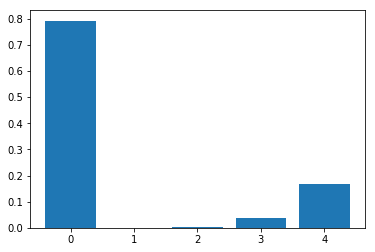

[102.   0.   0.   0.   0.]


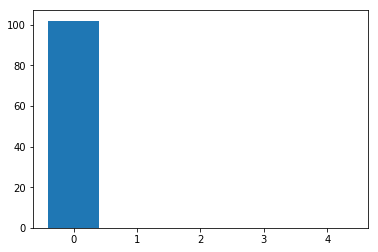

(40000, 634) (40000, 1000)
(102, 634) (102, 1000)
[9.6251726e-01 2.3104716e-02 6.7811101e-03 6.9854306e-03 6.1153865e-04]


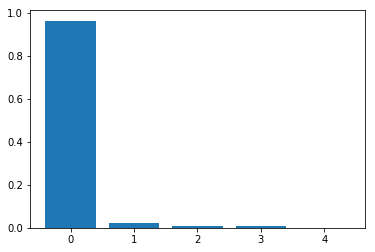

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def show_target_predict(n = 5):
    image_target = x_train[0][sample_id_need_copy:sample_id_need_copy+1,:]
    text_target = x_train[1][sample_id_need_copy:sample_id_need_copy+1,:]

    passive_output = [passive_model_image(image_target), passive_model_text(text_target)]
    active_output = active_model(passive_output)

    output_distribution = np.average(active_output, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)

    plt.show()

def show_semantic_label(n = 5):
    output_distribution = np.sum(y_backdoor, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)

    plt.show()
    
def show_semantic_predict(n = 5):
    print(image_test.shape, text_test.shape)
    print(image_backdoor.shape, text_backdoor.shape)

    passive_output = [passive_model_image(image_backdoor), passive_model_text(text_backdoor)]
    active_output = active_model(passive_output)

    output_distribution = np.average(active_output, axis=0)
    print(output_distribution)

    X = np.arange(n)
    plt.bar(X, output_distribution)
    plt.savefig('exp2_poison_predict.png')
    plt.show()
        
show_target_predict()
show_semantic_label()
show_semantic_predict()

In [ ]:
class MyLinearModel(Model):
  def __init__(self):
    super(MyLinearModel, self).__init__()
    self.flatten = Flatten()
    self.d1 = Dense(class_num, activation='softmax', name="dense1")

  def call(self, x):
    x = self.flatten(x)
    return self.d1(x)

model = MyLinearModel()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

EPOCHS = 5

for epoch in range(EPOCHS):
  # For each batch of images and labels
  for images, labels in train_ds:
    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    print(gradients[0].shape, gradients[1].shape)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

  for test_images, test_labels in test_ds:
    predictions = model(test_images)
    t_loss = loss_object(test_labels, predictions)

    test_loss(t_loss)
    test_accuracy(test_labels, predictions)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

In [ ]:
with tf.GradientTape() as tape:
    a = tf.constant(2.)
    b = tf.constant(1.)
    tape.watch(a)
    tape.watch(b)
    c = tf.multiply(a, b)
g = tape.gradient(c, [a, b])
print(g)

In [ ]:
start = 341
print(start + np.argmax(y_train[start:,0]==1))

In [ ]:
passive_text_output = passive_model_text(train_X_text)

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, init='pca', random_state=0, verbose=1)
tsne.fit_transform(passive_text_output.numpy())  #进行数据降维,降成两维
#a=tsne.fit_transform(data_zs) #a是一个array,a相当于下面的tsne_embedding_
tsne = pd.DataFrame(tsne.embedding_, index=data_zs.index) #转换数据格式

In [ ]:
import pandas as pd
tsne2 = pd.DataFrame(tsne.embedding_) #转换数据格式


In [ ]:
import matplotlib.pyplot as plt 

label_train = np.argmax(train_Y, axis=1)
l_lst = []
c_lst = []
oo = passive_text_output.numpy()
print(oo)
for label_show in range(class_num-1, -1, -1):
    d = tsne2[label_train==label_show]
    l = plt.scatter(d[0],d[1], s=2)
    l_lst.append(l)
    c_lst.append('class ' + str(label_show))
plt.legend(l_lst, c_lst, loc = 'best')
plt.show()

In [35]:
[acc_train, acc_test, acc_test_label, acc_backdoor, loss_train, loss_test, loss_backdoor] = result_list[1]
print(acc_test[-1])

tf.Tensor(0.886475, shape=(), dtype=float32)
